#1.Reading the data and visualizing it

In [68]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_error

In [69]:
# reading the csv into a dataframe
champagnes = pd.read_csv("/content/perrin-freres-monthly-champagne-.csv")

In [70]:
#Shape of the dataframe
print(champagnes.shape)

(107, 2)


We have data for 107 months

In [71]:
#Checking first 5 rows of the dataframe
print(champagnes.head())

     Month  Perrin Freres monthly champagne sales millions ?64-?72
0  1964-01                                             2815.0     
1  1964-02                                             2672.0     
2  1964-03                                             2755.0     
3  1964-04                                             2721.0     
4  1964-05                                             2946.0     


In [72]:
#Checking for null values
null_rows = champagnes.isnull().any(axis=1)
print(champagnes[null_rows])

                                                 Month  \
105                                                NaN   
106  Perrin Freres monthly champagne sales millions...   

     Perrin Freres monthly champagne sales millions ?64-?72  
105                                                NaN       
106                                                NaN       


In [73]:
# Dropping the rows with null values
champagnes_cleaned = champagnes.dropna()

In [74]:
# First five rows of the cleaned dataset
champagnes_cleaned.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [75]:
#Renaming the sales column
champagnes_cleaned = champagnes_cleaned.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'})

In [76]:
champagnes_cleaned.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [77]:
champagnes_cleaned.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [78]:
# Converting the month to a datetime object
champagnes_cleaned['Month'] = pd.to_datetime(champagnes_cleaned['Month'])

In [79]:
champagnes_cleaned.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [80]:
#Setting month as the index for time series forecasting
champagnes_cleaned = champagnes_cleaned.set_index('Month')

In [81]:
champagnes_cleaned.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [82]:
#Using the describe method to get the statistical properties of the Sales column
champagnes_cleaned.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<Axes: xlabel='Month'>

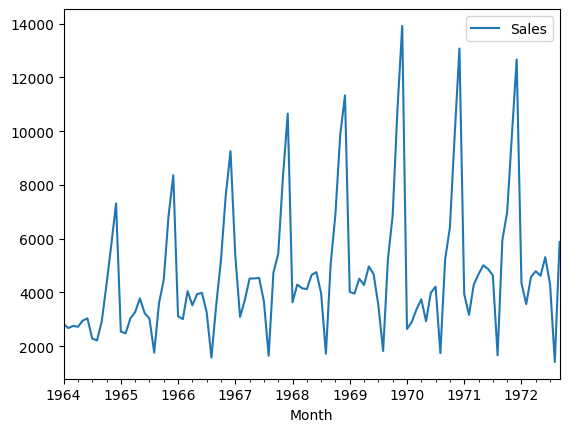

In [83]:
# Visualizing the sales data
champagnes_cleaned.plot()

Champagne sales seem to grow during new years eve or holidays.

#2.Check for stationarity using ADF test


ADF test  - check for stationarity
H0 (null hypothesis) - Data is non-stationary
H1 - Data is stationary)

In [84]:
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [85]:
adfuller_test(champagnes_cleaned['Sales'])

ADF Test Statistic : -1.8335930563276215
p-value : 0.36391577166024586
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


The sales data is not stationary, so now we need to make the data stationary before using it for modelling

#3.Differencing the data to get a steady mean - step towards stationarity

In [86]:
# Shifting the data by 1 month
champagnes_cleaned['1 Month Diff'] = champagnes_cleaned['Sales'] - champagnes_cleaned['Sales'].shift(1)

In [87]:
champagnes_cleaned.head(10)

,Sales,1 Month Diff
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0
1964-06-01,3036.0,90.0
1964-07-01,2282.0,-754.0
1964-08-01,2212.0,-70.0
1964-09-01,2922.0,710.0


In [88]:
# Differencing the data by 12 months
champagnes_cleaned['12 Seasonal Diff'] = champagnes_cleaned['Sales'] - champagnes_cleaned['Sales'].shift(12)

In [89]:
champagnes_cleaned.head(15)

,Sales,1 Month Diff,12 Seasonal Diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [90]:
# Checking for stationarity again
adfuller_test(champagnes_cleaned['12 Seasonal Diff'].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

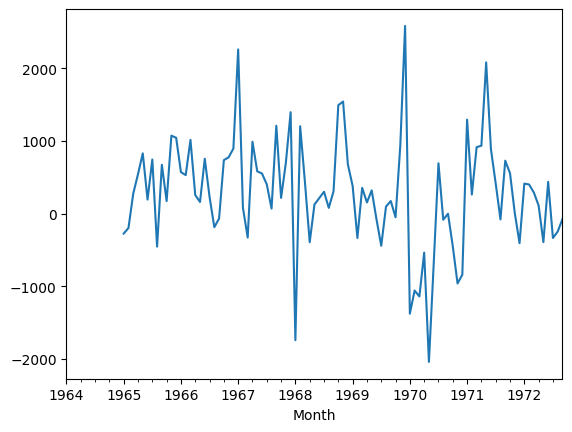

In [91]:
champagnes_cleaned['12 Seasonal Diff'].plot()

#4. Fitting an ARIMA model

Can see that the mean is almost constant, so now lets try to fit an ARIMA model on this data

For identifying the AR lags (p) and MA lags (q), we need the PACF and ACF plots respectively

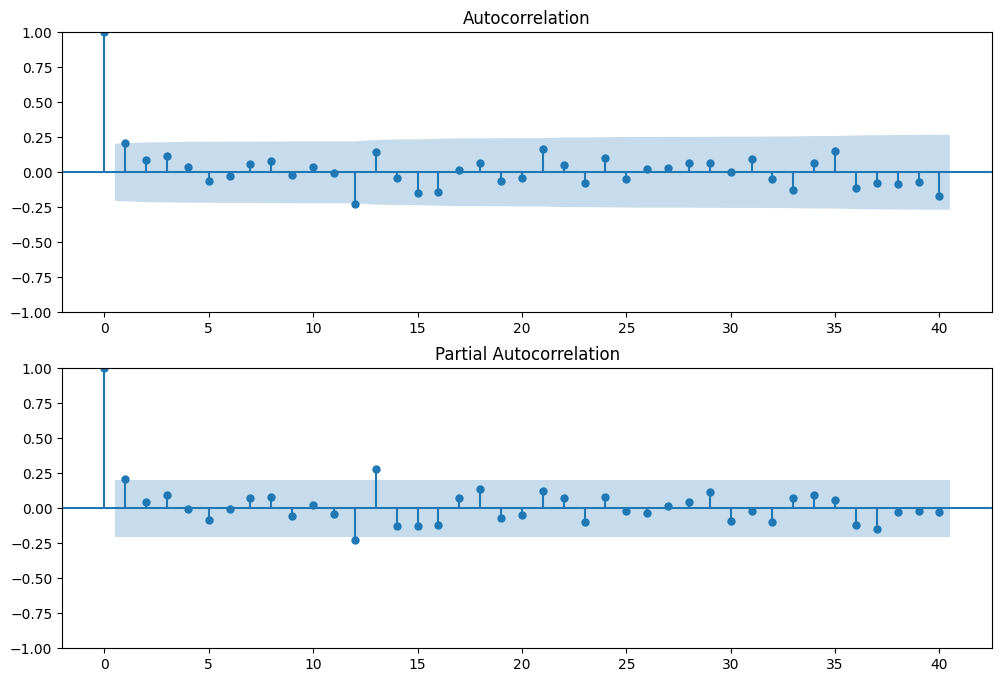

In [92]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(champagnes_cleaned['12 Seasonal Diff'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(champagnes_cleaned['12 Seasonal Diff'].iloc[13:],lags=40,ax=ax2)

Deciding on p=1, d=1, q=0 or 1 and fitting an ARIMA model on the data

In [93]:
arima_model = ARIMA(champagnes_cleaned['Sales'],order=(1,1,1))
arima_model_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [94]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Mon, 16 Sep 2024   AIC                           1911.627
Time:                        23:04:34   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      4.001      0.000       0.232       0.677
ma.L1         -0.9667      0.056    -17.329      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.472      0.000    4.02e+06    6.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

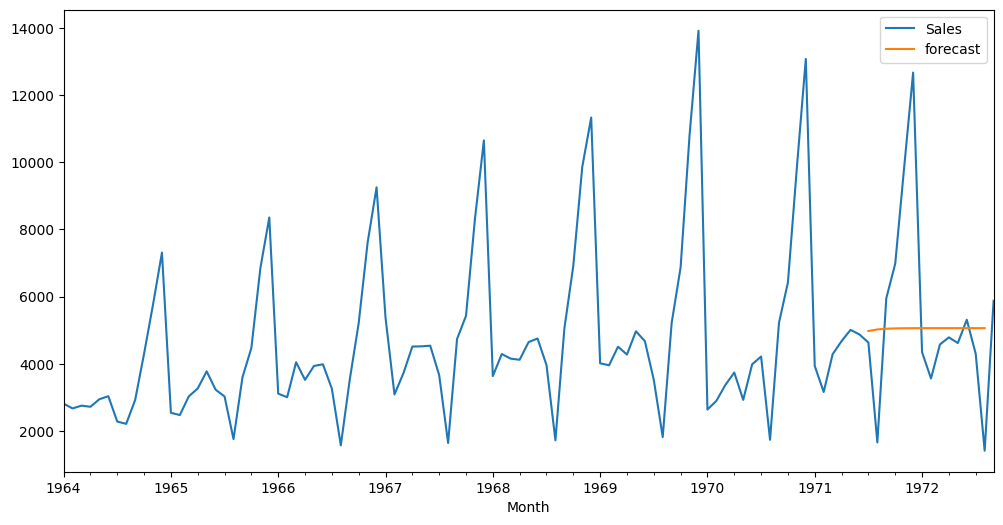

In [95]:
champagnes_cleaned['forecast'] = arima_model_fit.predict(start=90,end=103,dynamic=True)
champagnes_cleaned[['Sales','forecast']].plot(figsize=(12,6))

In [96]:
# Get the actual values and the forecasted values for the test period
actual = champagnes_cleaned['Sales'][90:104]  # Using the same range as forecast
forecast = champagnes_cleaned['forecast'][90:104]

# Calculate MAE
mae = mean_absolute_error(actual, forecast)

# Print the result
print(f'Mean Absolute Error (MAE) using ARIMA 1: {mae}')

Mean Absolute Error (MAE) using ARIMA 1: 1930.146144288521


We can see that the ARIMA model with q as 1 isn't that great at forecasting

In [97]:
# Trying an ARIMA model with q = 0
arima_model_2 = ARIMA(champagnes_cleaned['Sales'],order=(1,1,0))
arima_model_2_fit = arima_model_2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [98]:
arima_model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -966.444
Date:                Mon, 16 Sep 2024   AIC                           1936.888
Time:                        23:04:56   BIC                           1942.177
Sample:                    01-01-1964   HQIC                          1939.031
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0917      0.152     -0.603      0.547      -0.390       0.206
sigma2       6.97e+06   8.84e+05      7.885      0.000    5.24e+06     8.7e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               109.37
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               4.47   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

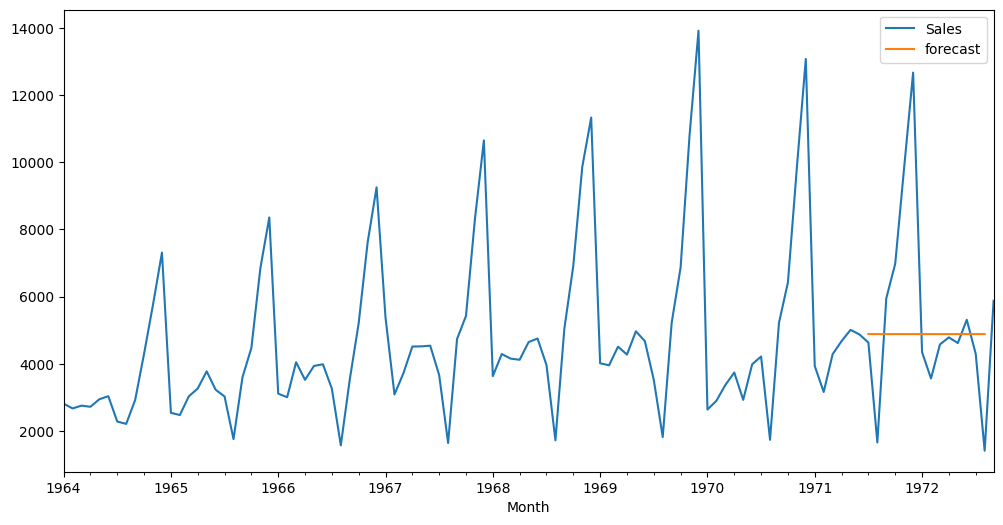

In [99]:
champagnes_cleaned['forecast'] = arima_model_2_fit.predict(start=90,end=103,dynamic=True)
champagnes_cleaned[['Sales','forecast']].plot(figsize=(12,6))

In [100]:
# Get the actual values and the forecasted values for the test period
actual = champagnes_cleaned['Sales'][90:104]  # Using the same range as forecast
forecast = champagnes_cleaned['forecast'][90:104]

# Calculate MAE
mae = mean_absolute_error(actual, forecast)

# Print the result
print(f'Mean Absolute Error (MAE) using ARIMA 2: {mae}')

Mean Absolute Error (MAE) using ARIMA 2: 1886.4013550348677


Even with q = 0, ARIMA isn't able to produce great forecasts. This is because there is seasonality in the data.

# 5.Trying to fit SARIMAX to account for the seasonality

In [101]:
sarima_model = sm.tsa.statespace.SARIMAX(champagnes_cleaned['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
sarima_model_fit = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [102]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Mon, 16 Sep 2024   AIC                           1486.804
Time:                                    23:05:15   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

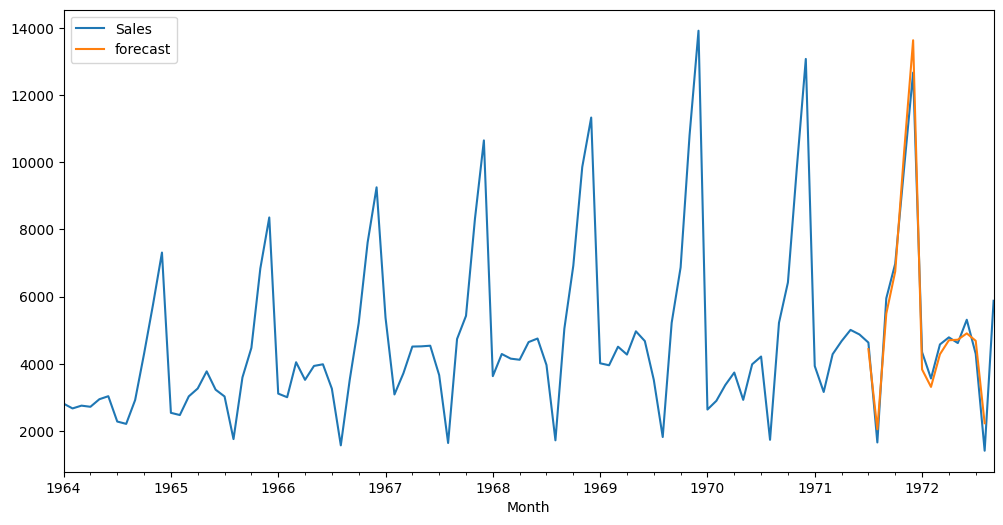

In [103]:
champagnes_cleaned['forecast'] = sarima_model_fit.predict(start=90,end=103,dynamic=True)
champagnes_cleaned[['Sales','forecast']].plot(figsize=(12,6))

In [104]:
# Get the actual values and the forecasted values for the test period
actual = champagnes_cleaned['Sales'][90:104]  # Using the same range as forecast
forecast = champagnes_cleaned['forecast'][90:104]

# Calculate MAE
mae = mean_absolute_error(actual, forecast)

# Print the result
print(f'Mean Absolute Error (MAE) using SARIMA: {mae}')

Mean Absolute Error (MAE) using SARIMA: 397.7823999416379


Since SARIMA takes into account the seasonality, the forecasts are much better

# 6.Future forecasting

In [39]:
#Creating a dataset with future dates
future_dates=[champagnes_cleaned.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [40]:
future_sales = pd.DataFrame(index=future_dates[1:],columns=champagnes_cleaned.columns)

In [41]:
future_sales.tail()

,Sales,1 Month Diff,12 Seasonal Diff,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [79]:
future_df=pd.concat([champagnes_cleaned, future_sales])

<ipython-input-79-2d82469d8f33>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([champagnes_cleaned, future_sales])


<Axes: >

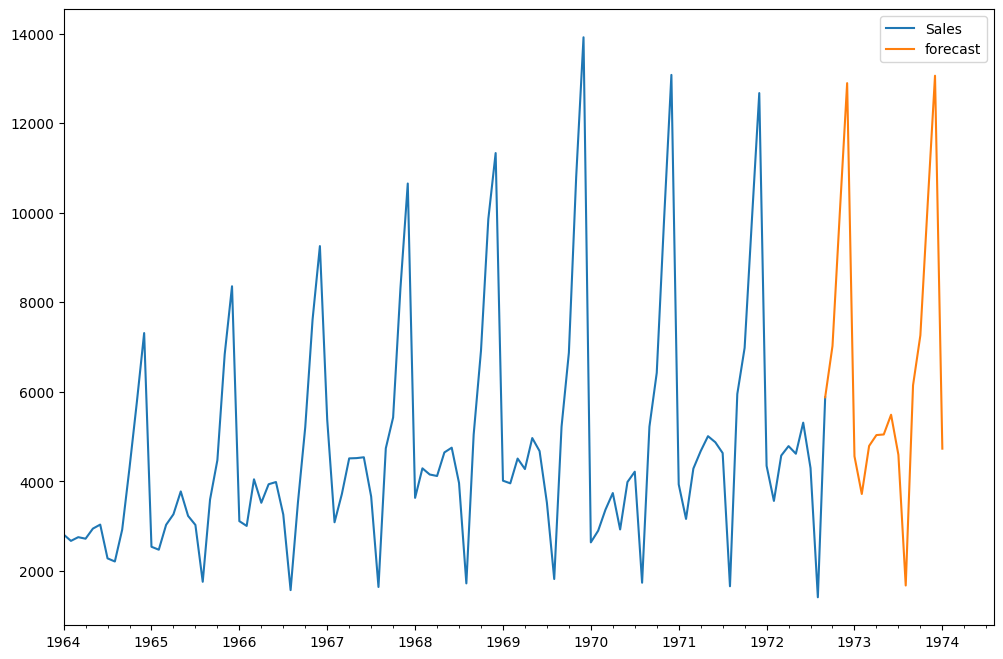

In [80]:
future_df['forecast'] = sarima_model_fit.predict(start = 104, end = 120, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

Reference: https://www.youtube.com/watch?v=2XGSIlgUBDI

Dataset: https://www.kaggle.com/datasets/anupamshah/perrin-freres-monthly-champagne-sales/data